# Equivalent layer technique for estimating total magnetization direction using regular grid

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
import string as st
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'regular_EQL_magdirection_RM_calculation.ipynb'

#### Importing auxiliary functions

In [4]:
dir_modules = '../../../mypackage'
sys.path.append(dir_modules)

In [5]:
import auxiliary_functions as fc

#### Loading properties of the model

In [6]:
with open('data/model_prism.pickle') as f:
        model_prism = pickle.load(f)

#### Loading properties grid

In [7]:
with open('data/regular_grid.pickle') as f:
        reg_grid = pickle.load(f)

#### Loading data

In [8]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [9]:
result_RM_reg = dict()

### Saving files

In [10]:
saved_files = []

## Observation area

In [11]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (reg_grid['area'][1], 
                                                                                                reg_grid['area'][0],
                                                                                                reg_grid['area'][3],
                                                                                                reg_grid['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


### reg_grid survey information

In [12]:
print 'Shape : (%.0f,%.0f)'% reg_grid['shape'] 
print 'Number of data: %.1f' % reg_grid['N']
print 'dx: %.1f m' % reg_grid['dx']
print 'dy: %.1f m ' % reg_grid['dy']

Shape : (25,25)
Number of data: 625.0
dx: 500.0 m
dy: 500.0 m 


## Properties of the model

### Main field

In [13]:
inc_gf,dec_gf = model_prism['main_field']

In [14]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 30.0 degree
Main field declination: 40.0 degree


### Magnetization direction

In [15]:
print 'Intensity: %.1f A/m' % model_prism['m_R']
print 'Inclination: %.1f degree' % model_prism['inc_R']
print 'Declination: %.1f degree' % model_prism['dec_R']

Intensity: 5.0 A/m
Inclination: 50.0 degree
Declination: 15.0 degree


In [16]:
inc_R,dec_R = model_prism['inc_R'],model_prism['dec_R']

## Generating the layer with my function 

In [17]:
h = 1500.

#### Generating a layer

In [18]:
shape_layer = (reg_grid['shape'][0],reg_grid['shape'][1])

In [19]:
xs,ys,zs = regular(reg_grid['area'],shape_layer,h)

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [20]:
i_pos = 1500

In [21]:
it_max = 30

In [22]:
it_marq = 15

In [23]:
lamb = 10.
dlamb = 100.

In [24]:
eps_e = 1e-4
eps_i = 1e-4

In [25]:
mu_list = [1e2,1e3,1e4,1e5,5*2e5,1e6,1e7]

In [26]:
mu_norm = []
norm_r = []
norm_m = []
m_est = []
incl_est = []
decl_est = []
phi_list = []
for i in mu_list:
    m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
        data['tfa_obs_prism_RM_reg'],reg_grid['x'],reg_grid['y'],
        reg_grid['z'],xs,ys,zs,inc_gf,dec_gf,-10.,-10.,lamb,dlamb,i_pos,it_max,
        it_marq,eps_e,eps_i,i)
    G = fc.sensitivity_mag(reg_grid['x'],reg_grid['y'],reg_grid['z'],
                       xs,ys,zs,inc_gf,dec_gf,inc_est,dec_est)
    tfpred = np.dot(G,m_LM)
    r = data['tfa_obs_prism_RM_reg'] - tfpred 
    
    norm_r.append(np.sqrt(np.sum(r*r)))
    norm_m.append(np.sqrt(np.sum(m_LM*m_LM)))
    m_est.append(m_LM)
    incl_est.append(inc_est)
    decl_est.append(dec_est)
    phi_list.append(phi)

i = 0
1.96163516648 -5.08185594995
i = 1
9.36118491395 -3.04449627042
i = 2
14.0280226473 -2.17463605111
i = 3
17.3216719406 -1.64134924467
i = 4
19.838487432 -1.27331417616
i = 5
21.8478750855 -0.980659992987
i = 6
23.5182098397 -0.777857209958
i = 7
24.9694041565 -0.629207733498
i = 8
26.2549226277 -0.512189707778
i = 9
27.4051229418 -0.410880027379
i = 10
28.4439971431 -0.316515592562
i = 11
29.3894249293 -0.225337013748
i = 12
30.25559392 -0.135928505464
i = 13
31.0606116075 -0.0326619975585
i = 14
31.8132607205 0.0870240147994
i = 15
32.5219549068 0.220251559493
i = 16
33.1971267435 0.365935152789
i = 17
33.8424011394 0.523893543655
i = 18
34.4600898849 0.693871297536
i = 19
35.0526230737 0.875922821613
i = 20
35.6231322156 1.07321816784
i = 21
36.1733174571 1.2851401381
i = 22
36.7046499841 1.51091204775
i = 23
37.2183785171 1.74887774049
i = 24
37.7157441442 1.9983136742
i = 25
38.1978182709 2.25837432311
i = 26
38.6659480076 2.52866397735
i = 27
39.1210244778 2.80873906602
i = 

34.4666019466 0.717224550059
i = 19
35.0594035572 0.901977299587
i = 20
35.6300970289 1.10211159169
i = 21
36.1804002439 1.31662796642
i = 22
36.7119149599 1.54380000704
i = 23
37.2257282971 1.78311918737
i = 24
37.7231188913 2.03379005579
i = 25
38.2051094982 2.29494885829
i = 26
38.6730687095 2.56632701344
i = 27
39.1278993595 2.8474999594
i = 28
39.570843702 3.13877340142
i = 29
40.0024011417 3.43985492541
i = 30
40.4233489201 3.74981110611
i = 31
40.8342562771 4.0679957889
i = 32
41.2356684362 4.39358653628
i = 33
41.6282457196 4.7260005354
i = 34
42.0111792302 5.06574450466
i = 35
42.3841238239 5.41463935277
i = 36
42.7468478991 5.77215399211
i = 37
43.098540769 6.13763689956
i = 38
43.4391111227 6.50987567403
i = 39
43.7688328697 6.88743310184
i = 40
44.0879163391 7.2684027172
i = 41
44.3967241882 7.6521571738
i = 42
44.6955397536 8.03765781928
i = 43
44.984608808 8.42374387315
i = 44
45.2645455395 8.81100299376
i = 45
45.5358309981 9.19972508158
i = 46
45.794092257 9.58655814036

53.1687899872 11.1661072361
i = 38
53.2498963466 11.1638404455
i = 39
53.2498963466 11.1638404455


### L-curve visualization

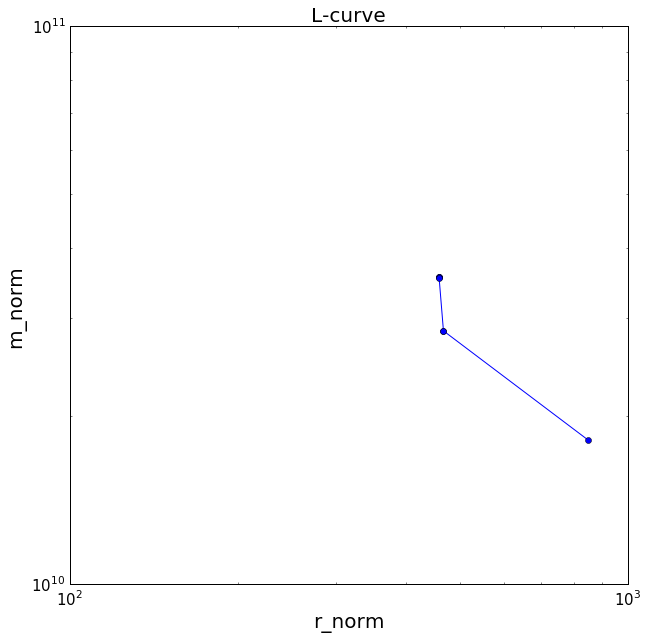

In [27]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.loglog(norm_r,norm_m, 'b-')
plt.loglog(norm_r,norm_m, 'bo')
plt.title('L-curve', fontsize=title_font)
plt.xlabel('r_norm', fontsize = title_font)
plt.ylabel('m_norm', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/regular/Lcurve_RM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Results

In [28]:
result_RM_reg['magnetic_moment'] = m_est
result_RM_reg['inc_est'] = incl_est
result_RM_reg['dec_est'] = decl_est
result_RM_reg['layer_depth'] = h
result_RM_reg['reg_parameter'] = mu_list
result_RM_reg['phi'] = phi_list

#### Generating .pickle file

In [29]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
result_RM_reg['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [30]:
file_name = 'data/result_RM_reg.pickle'
with open(file_name, 'w') as f:
    pickle.dump(result_RM_reg, f)
    
saved_files.append(file_name)


### Saved files

In [31]:
with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
    q.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    q.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        q.write('*  `%s` \n' % (sf))

1  figs/regular/Lcurve_RM.png
2  figs/regular/Lcurve_RM.eps
3  data/result_RM_reg.pickle
